# Requirements

In [5]:
# Required libraries.
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import spacy
import string
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
from spacy import tokenizer
from spacy.lang.en import English
nlp = English()
tkz = tokenizer.Tokenizer(nlp.vocab)
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import re
from bs4 import BeautifulSoup
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import unicodedata
import pickle

# The Model(s)

In [8]:
# Import dataset with the embedding

embedding1 = pd.read_pickle('/Users/simonefacchiano/Desktop/Data Science/SL/Project/embedding_100k.pkl')
embedding1 = embedding1[['post', 'age', 'gender', 'embedding']]
embedding1

,post,age,gender,embedding
0,ooh shiny new commenting,16,female,"[-0.18770814, -0.13998552, 0.019073976, 0.0225..."
1,today parade suked wasnt bad band year battle ...,14,male,"[-0.110725485, 0.043310776, 0.020091565, -0.06..."
2,know anymore concerned everyday want bold face...,24,female,"[-0.08226248, -0.03889151, 0.029810807, 0.0900..."
3,roof sunset posted paul,24,male,"[-0.046943568, 0.13227944, 0.02199171, 0.00461..."
4,god love nanny absolutely greatest woman earth...,23,female,"[-0.04256986, -0.072457716, 0.005980614, 0.014..."
...,...,...,...,...
99995,wauh exam season surrounding tense amportant e...,24,female,"[-0.006393074, 0.03347828, 0.033901136, -0.021..."
99996,u n shows s need half intelligent person knows...,24,male,"[-0.03396106, -0.028289719, 0.0066081965, -0.0..."
99997,outta sight outta mind outta heart yeah right ...,35,male,"[-0.017426101, -0.069821574, 0.055012133, 0.04..."
99998,ding dong nami na guid sang blogger ah hehe es...,26,male,"[-0.07841086, 0.030480236, 0.041061677, -0.012..."


In [9]:
embedding2 = pd.read_pickle('/Users/simonefacchiano/Desktop/Data Science/SL/Project/embedding_100k_2.pkl')
embedding2 = embedding2[['post', 'age', 'gender', 'embedding']]
embedding2

,post,age,gender,embedding
100000,love test test test non stop cant stop testing...,16,male,"[-0.057716005, -0.04005825, -0.002310888, -0.0..."
100001,lol yay going movieworld soon happy oh happy t...,14,female,"[-0.041464932, -0.034795586, 0.048872694, 0.00..."
100002,tamer ziara associated press writer rafah gaza...,27,male,"[-0.024696432, 0.036157, -0.046597987, 0.06194..."
100003,society consisting men women content apply pro...,34,male,"[0.039336678, 0.057090227, -0.011589597, -0.00..."
100004,ve blown away entire evening reaping fruits fi...,17,male,"[0.020673048, -0.057360034, -0.02444625, -0.00..."
...,...,...,...,...
199995,hmm says d drink wow sound like frilly drinks ...,24,male,"[-0.013961518, -0.0123876715, 0.05635563, 0.05..."
199996,shopping saturday target saw mother son baseba...,25,male,"[-0.06175793, 0.05059001, -0.013568009, -0.032..."
199997,monday monday weeks greece sunshine pack thing...,27,female,"[-0.02756931, -0.0027997827, 0.0756554, 0.0211..."
199998,good news far spoke nurse morning asked batter...,33,male,"[-0.009163862, 0.015796268, 0.07616058, 0.0500..."


In [10]:
embedding = pd.concat([embedding1, embedding2])
embedding

,post,age,gender,embedding
0,ooh shiny new commenting,16,female,"[-0.18770814, -0.13998552, 0.019073976, 0.0225..."
1,today parade suked wasnt bad band year battle ...,14,male,"[-0.110725485, 0.043310776, 0.020091565, -0.06..."
2,know anymore concerned everyday want bold face...,24,female,"[-0.08226248, -0.03889151, 0.029810807, 0.0900..."
3,roof sunset posted paul,24,male,"[-0.046943568, 0.13227944, 0.02199171, 0.00461..."
4,god love nanny absolutely greatest woman earth...,23,female,"[-0.04256986, -0.072457716, 0.005980614, 0.014..."
...,...,...,...,...
199995,hmm says d drink wow sound like frilly drinks ...,24,male,"[-0.013961518, -0.0123876715, 0.05635563, 0.05..."
199996,shopping saturday target saw mother son baseba...,25,male,"[-0.06175793, 0.05059001, -0.013568009, -0.032..."
199997,monday monday weeks greece sunshine pack thing...,27,female,"[-0.02756931, -0.0027997827, 0.0756554, 0.0211..."
199998,good news far spoke nurse morning asked batter...,33,male,"[-0.009163862, 0.015796268, 0.07616058, 0.0500..."


In [30]:
# Import dataset with additional features (TODO: metti tutto insieme nel file di preprocessing)
features = pd.read_pickle('/Users/simonefacchiano/Desktop/Data Science/SL/Project/train_features.pkl')
features = features[['has_young_word', 'word_count', 'has_emoticon', 'has_punctuation', 'has_URL']]
features = features[:200000]

### Fix the labels for the model

In [12]:
# Notice: there is a little imbalancement here, due to the fact that we are working with the *first* 100k rows of the original dataset. Keep this in mind

embedding['age_class'] = pd.cut(
        embedding["age"],
        bins=[12, 18, 28, 50],
        labels=[0, 1, 2]
    ).astype("int")

In [13]:
embedding['gender'] = embedding['gender'].map({'male': 1, 'female': 0})

In [14]:
# Select and re-order the columns for a better visualization:
embedding = embedding[['post', 'embedding', 'gender', 'age_class']]

In [16]:
embedding

,post,embedding,gender,age_class
0,ooh shiny new commenting,"[-0.18770814, -0.13998552, 0.019073976, 0.0225...",0,0
1,today parade suked wasnt bad band year battle ...,"[-0.110725485, 0.043310776, 0.020091565, -0.06...",1,0
2,know anymore concerned everyday want bold face...,"[-0.08226248, -0.03889151, 0.029810807, 0.0900...",0,1
3,roof sunset posted paul,"[-0.046943568, 0.13227944, 0.02199171, 0.00461...",1,1
4,god love nanny absolutely greatest woman earth...,"[-0.04256986, -0.072457716, 0.005980614, 0.014...",0,1
...,...,...,...,...
199995,hmm says d drink wow sound like frilly drinks ...,"[-0.013961518, -0.0123876715, 0.05635563, 0.05...",1,1
199996,shopping saturday target saw mother son baseba...,"[-0.06175793, 0.05059001, -0.013568009, -0.032...",1,1
199997,monday monday weeks greece sunshine pack thing...,"[-0.02756931, -0.0027997827, 0.0756554, 0.0211...",0,1
199998,good news far spoke nurse morning asked batter...,"[-0.009163862, 0.015796268, 0.07616058, 0.0500...",1,2


In [116]:
# features = features[['has_young_word', 'has_punctuation', 'has_URL']]

In [100]:
data = pd.concat([embedding, features], axis = 1)
data
# 200.000 righe

,post,embedding,gender,age_class,has_young_word,word_count,has_emoticon,has_punctuation,has_URL
0,ooh shiny new commenting,"[-0.18770814, -0.13998552, 0.019073976, 0.0225...",0,0,0,4,0,0,0
1,today parade suked wasnt bad band year battle ...,"[-0.110725485, 0.043310776, 0.020091565, -0.06...",1,0,1,48,0,0,0
2,know anymore concerned everyday want bold face...,"[-0.08226248, -0.03889151, 0.029810807, 0.0900...",0,1,1,80,0,1,0
3,roof sunset posted paul,"[-0.046943568, 0.13227944, 0.02199171, 0.00461...",1,1,0,7,0,0,1
4,god love nanny absolutely greatest woman earth...,"[-0.04256986, -0.072457716, 0.005980614, 0.014...",0,1,0,730,0,1,0
...,...,...,...,...,...,...,...,...,...
199995,hmm says d drink wow sound like frilly drinks ...,"[-0.013961518, -0.0123876715, 0.05635563, 0.05...",1,1,0,64,1,1,0
199996,shopping saturday target saw mother son baseba...,"[-0.06175793, 0.05059001, -0.013568009, -0.032...",1,1,0,199,0,0,0
199997,monday monday weeks greece sunshine pack thing...,"[-0.02756931, -0.0027997827, 0.0756554, 0.0211...",0,1,0,85,0,1,0
199998,good news far spoke nurse morning asked batter...,"[-0.009163862, 0.015796268, 0.07616058, 0.0500...",1,2,0,69,0,0,0


### Removing specific rows

(array([9.0858e+04, 7.2480e+03, 1.2680e+03, 3.3200e+02, 1.2800e+02,
        5.5000e+01, 4.0000e+01, 1.7000e+01, 8.0000e+00, 1.7000e+01]),
 array([   0. ,  498.4,  996.8, 1495.2, 1993.6, 2492. , 2990.4, 3488.8,
        3987.2, 4485.6, 4984. ]),
 <BarContainer object of 10 artists>)

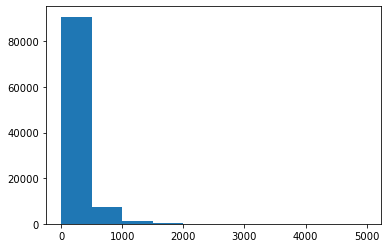

In [229]:
import matplotlib.pyplot as plt

plt.hist(data[data.word_count < 5000].word_count)

In [59]:
# Rimuovi le righe con word count inferiore a 5 o superiore a 1000
data = data[(data['word_count'] >= 5) & (data['word_count'] <= 1000)]
data.shape

(189417, 9)

In [47]:
small_data = data[:10000]

# Before we start... most common words per gender

In [141]:
from nltk.probability import FreqDist

def most_common_words(train):
    stop = set(stopwords.words("english"))
    corpus = [word for i in train["post"].str.split().values.tolist() for word in i if (word not in stop)]
    most_common = FreqDist(corpus).most_common(1000)
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)   
    return words #, frequency

In [146]:
male_words = most_common_words(data[data.gender == 1])
female_words = most_common_words(data[data.gender == 0])

popular_male = list(set(male_words) - set(female_words))
popular_female = list(set(female_words) - set(male_words))

In [159]:
# creaiamo due variabili apposta
features['word_male'] = data['post'].str.contains('|'.join(popular_male), case=False, regex=True).astype(int)
features['word_female'] = data['post'].str.contains('|'.join(popular_female), case=False, regex=True).astype(int)

## Predicting the Gender of the author

Note: the genders are balanced

In [124]:
# Let's first identify the feature matrix and the labels

X = data['embedding'].to_list() # ,'has_young_word', 'word_count', 'has_emoticon', 'has_punctuation', 'has_URL'
# X = pd.DataFrame(embedding['embedding'].to_list(), columns=[f'embedding_{i+1}' for i in range(384)])
# X = pd.concat([X, features], axis = 1)
y = data['gender'].to_list()

In [125]:
# Create the train & validation sets
# In this way, every operation of fine tuning will depend on the data observed in the validation, while the final assessment for the quality of the model will be made on the test set

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y) # stratification on the y to avoid class imbalancement

print(f'The train set has {len(X_train)} rows, while the validation set contains {len(X_val)} rows: 80% vs 20%.')

The train set has 160000 rows, while the validation set contains 40000 rows: 80% vs 20%.


##### Logistic Regression

In [126]:
# We start with a very simple Logistic Regression to see how it works

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [127]:
from sklearn import metrics

predicted = lr.predict(X_val)

print(f'Logistic Regression Accuracy : {metrics.accuracy_score(y_val, predicted)}')
print(f'Logistic Regression Precision: {metrics.precision_score(y_val, predicted)}')
print(f'Logistic Regression Recall   : {metrics.recall_score(y_val, predicted)}')

####

Logistic Regression Accuracy : 0.644725
Logistic Regression Precision: 0.6507093062935699
Logistic Regression Recall   : 0.6545062273217613


In [128]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, predicted)

array([[12441,  7165],
       [ 7046, 13348]])

### Regularization

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [10],
    'penalty': ['l1', 'l2']
    #'max_iter': list(range(100, 800, 200)),
    #'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
lr_search = GridSearchCV(lr, param_grid=param_grid, refit = True, verbose = 3, cv=5)

# fitting the model for grid search 
lr_search.fit(X_train, y_train)
lr_search.best_params_
# summarize
print('Best Accuracy: %.3f' % lr_search.best_score_)
print('Config: %s' % lr_search.best_params_)

In [86]:
lr = LogisticRegression(C = 10, penalty = 'l2')
lr.fit(X_train, y_train)

predicted = lr.predict(X_val)

print(f'Logistic Regression Accuracy : {metrics.accuracy_score(y_val, predicted)}')

Logistic Regression Accuracy : 0.6499049730757048


#### XgBoost

In [44]:
import xgboost as xgb

In [48]:
X = small_data['embedding'].to_list() # ,'has_young_word', 'word_count', 'has_emoticon', 'has_punctuation', 'has_URL'
y = small_data['gender'].to_list()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y)

In [52]:
# XGBoost (different learning rate)
learning_rate_range = np.arange(0.01, 1, 0.1)
val_XG = [] 
train_XG = []
for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta = lr)
    xgb_classifier.fit(X_train, y_train)
    train_XG.append(xgb_classifier.score(X_train, y_train))
    val_XG.append(xgb_classifier.score(X_val, y_val))

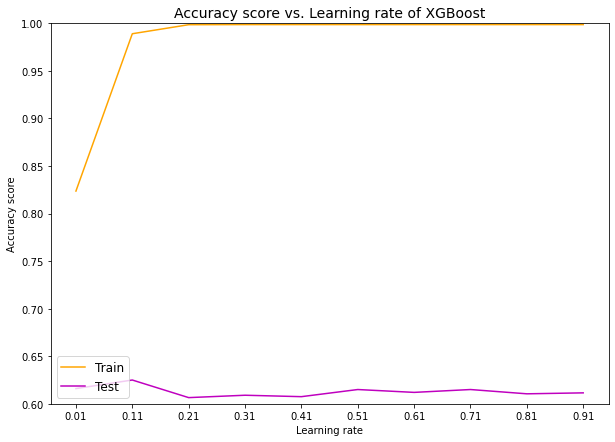

In [53]:
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
plt.plot(learning_rate_range, val_XG, c='m', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()    

### What if we add features?

In [160]:
features.columns

Index(['has_young_word', 'word_count', 'has_emoticon', 'has_punctuation',
       'has_URL', 'word_male', 'word_female'],
      dtype='object')

In [166]:
X = pd.DataFrame(data['embedding'].to_list(), columns=[f'embedding_{i+1}' for i in range(384)])
X = pd.concat([X, features[['word_male']]], axis = 1) # prendiamo solo le emoticon e le parole giovanili come features
y = data['gender'].to_list()

In [167]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y)

In [170]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=10)

In [171]:
predicted = lr.predict(X_val)

print(f'Logistic Regression Accuracy : {metrics.accuracy_score(y_val, predicted)}')
print(f'Logistic Regression Precision: {metrics.precision_score(y_val, predicted)}')
print(f'Logistic Regression Recall   : {metrics.recall_score(y_val, predicted)}')

Logistic Regression Accuracy : 0.6471
Logistic Regression Precision: 0.6542961069602832
Logistic Regression Recall   : 0.6526919682259488


In [236]:
param_grid = {
    'C': [0.1, 1, 10, 50, 100, 1000],
    'penalty': ['l1', 'l2'] #,
    # 'max_iter': list(range(100,800,100)),
    #'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
lr_search = GridSearchCV(lr, param_grid=param_grid, refit = True, verbose = 3, cv=5)

# fitting the model for grid search 
lr_search.fit(X_train , y_train)
lr_search.best_params_
# summarize
print('Mean Accuracy: %.3f' % lr_search.best_score_)
print('Config: %s' % lr_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.1s
[CV 2/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END .................C=0.1, penalty=l2;, score=0.637 total time=   1.5s
[CV 2/5] END .................C=0.1, penalty=l2;, score=0.633 total time=   1.5s
[CV 3/5] END .................C=0.1, penalty=l2;, score=0.631 total time=   1.5s
[CV 4/5] END .................C=0.1, penalty=l2;, score=0.625 total time=   1.5s
[CV 5/5] END .................C=0.1, penalty=l2;, score=0.636 total time=   1.6s
[CV 1/5] END .....................C=1, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .....................C=1, penalty=l

In [237]:
lr = LogisticRegression(C = 1, penalty = 'l2')
lr.fit(X_train, y_train)

LogisticRegression(C=1)

In [238]:
predicted = lr.predict(X_val)

print(f'Logistic Accuracy after Regularization : {metrics.accuracy_score(y_val, predicted)}')
print(f'Logistic Precision after Regularization: {metrics.precision_score(y_val, predicted)}')
print(f'Logistic Recall after Regularization   : {metrics.recall_score(y_val, predicted)}')

Logistic Accuracy after Regularization : 0.63975
Logistic Precision after Regularization: 0.6488718775181306
Logistic Recall after Regularization   : 0.6339927172522389


## Confrontare diversi modelli

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

#  defining models and associated parameters
models = [RandomForestClassifier(n_estimators = 100, max_depth=5, random_state=42), 
          LinearSVC(random_state=42),
          LogisticRegression(random_state=42)]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) # With StratifiedKFold, the folds are made by preserving the percentage of samples for each class.

scoring = ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro']

#  iterative loop print metrics from each model
for model in tqdm(models):
    model_name = model.__class__.__name__
    result = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring)
    print("%s: Mean Accuracy = %.2f%%; Mean F1-macro = %.2f%%; Mean recall-macro = %.2f%%; Mean precision-macro = %.2f%%" 
          % (model_name, 
             result['test_accuracy'].mean()*100, 
             result['test_f1_macro'].mean()*100, 
             result['test_recall_macro'].mean()*100, 
             result['test_precision_macro'].mean()*100))

 33%|███▎      | 1/3 [03:15<06:31, 195.59s/it]

RandomForestClassifier: Mean Accuracy = 61.73%; Mean F1-macro = 61.65%; Mean recall-macro = 61.67%; Mean precision-macro = 61.74%


 67%|██████▋   | 2/3 [03:42<01:36, 96.22s/it] 

LinearSVC: Mean Accuracy = 64.03%; Mean F1-macro = 64.02%; Mean recall-macro = 64.03%; Mean precision-macro = 64.03%


100%|██████████| 3/3 [04:06<00:00, 82.03s/it]

LogisticRegression: Mean Accuracy = 63.95%; Mean F1-macro = 63.95%; Mean recall-macro = 63.95%; Mean precision-macro = 63.95%


## Age_class

In [108]:
X = data['embedding'].to_list() # ,'has_young_word', 'word_count', 'has_emoticon', 'has_punctuation', 'has_URL'
# X = pd.DataFrame(embedding['embedding'].to_list(), columns=[f'embedding_{i+1}' for i in range(384)])
# X = pd.concat([X, features], axis = 1)
y = data['age_class'].to_list()

In [109]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y) # stratification on the y to avoid class imbalancement

print(f'The train set has {len(X_train)} rows, while the validation set contains {len(X_val)} rows: 80% vs 20%.')

The train set has 160000 rows, while the validation set contains 40000 rows: 80% vs 20%.


In [110]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [111]:
from sklearn import metrics

predicted = model.predict(X_val)

print(f'Multinomial Logistic Regression Accuracy : {metrics.accuracy_score(y_val, predicted)}')

Multinomial Logistic Regression Accuracy : 0.598975


In [112]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, predicted)

array([[ 7945,  5350,   212],
       [ 3203, 14993,   812],
       [  754,  5710,  1021]])

#### What if we add the features?

In [94]:
features.columns

Index(['has_young_word', 'word_count', 'has_emoticon', 'has_punctuation',
       'has_URL'],
      dtype='object')

In [101]:
X = pd.DataFrame(data['embedding'].to_list(), columns=[f'embedding_{i+1}' for i in range(384)])
X = pd.concat([X, features[['has_young_word', 'has_emoticon']]], axis = 1) # prendiamo solo le emoticon e le parole giovanili come features
y = data['age_class'].to_list()

In [102]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y) # stratification on the y to avoid class imbalancement

print(f'The train set has {len(X_train)} rows, while the validation set contains {len(X_val)} rows: 80% vs 20%.')

The train set has 160000 rows, while the validation set contains 40000 rows: 80% vs 20%.


In [105]:
model = LogisticRegression(multi_class='multinomial')
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [106]:
predicted = model.predict(X_val)

print(f'Multinomial Logistic Regression Accuracy : {metrics.accuracy_score(y_val, predicted)}')

Multinomial Logistic Regression Accuracy : 0.5999


In [107]:
confusion_matrix(y_val, predicted)

array([[ 7862,  5433,   212],
       [ 3152, 15062,   794],
       [  778,  5635,  1072]])